<a href="https://colab.research.google.com/github/chanzone-khm/pytorch_study/blob/main/Pytorch%E5%8B%89%E5%BC%B7%E4%BC%9A_%E5%89%8D%E6%9C%9F%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新しいセクション

# 課題説明

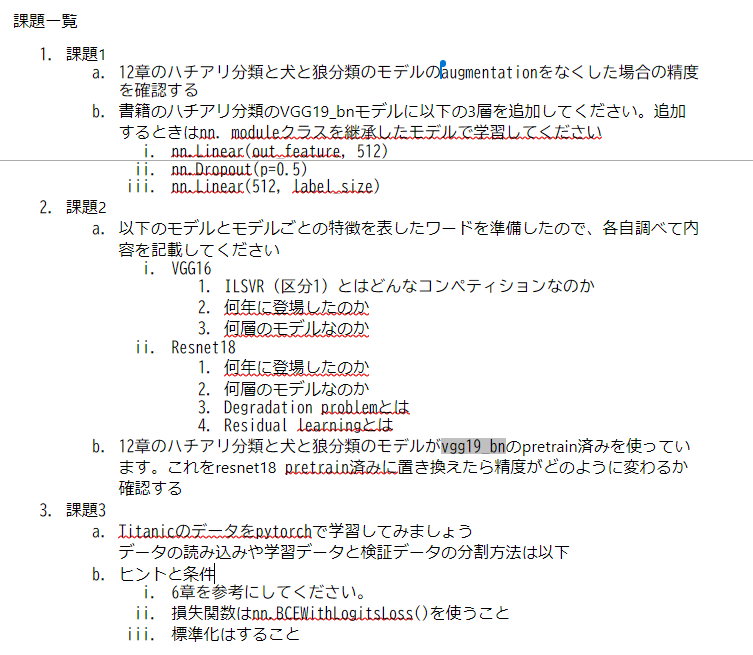

```python
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

titanic_dataset = sns.load_dataset('titanic') 
X = train[['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked', 'class', 'who', 'adult_male', 'alone']] 
y = train['survived'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
y_train, y_test = y_train.to_numpy(), y_test.to_numpy() 

#数値やラベルの処理 

#標準化 
def trans_standardscaler(input_train, input_test): 
    scaler = StandardScaler() 
    scaler.fit(input_train) 
    input_train = scaler.transform(input_train) 
    input_test = scaler.transform(input_test) 
    return input_train, input_test 
X_train, X_test, _ = trans_standardscaler(X_train, X_test) 

```

# import

In [1]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (1.7.0-5) ...


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [3]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 21.11 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Common Library for PyTorch
Author: M. Akaishi


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 課題1 ハチアリ

## a. 12章のハチアリ分類と犬と狼分類のモデルのaugmentationをなくした場合の精度を確認する 

### サンプルデータのダウンロード・回答

In [5]:
# サンプルデータのダウンロード
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 結果確認
print(w[-2])

2022-08-24 01:03:13 (61.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]


In [6]:
# データ解凍
w = !unzip -o hymenoptera_data.zip

# 結果確認
print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [7]:
# 解凍ファイルのtree表示
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

### transforms定義

In [ ]:
# Transforms定義


# train transforms augmentation 無し
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

# test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


# 新しいセクション

### DataLoader

In [ ]:
# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [ ]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


In [ ]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

In [ ]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04193 acc: 0.80328 val_loss: 0.01341, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.01683 acc: 0.93033 val_loss: 0.01171, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00469 acc: 0.98770 val_loss: 0.01241, val_acc: 0.94118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00188 acc: 0.99590 val_loss: 0.01420, val_acc: 0.94118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00194 acc: 0.99590 val_loss: 0.01477, val_acc: 0.92810


初期状態: 損失: 0.01341 精度: 0.96078
最終状態: 損失: 0.01477 精度: 0.92810


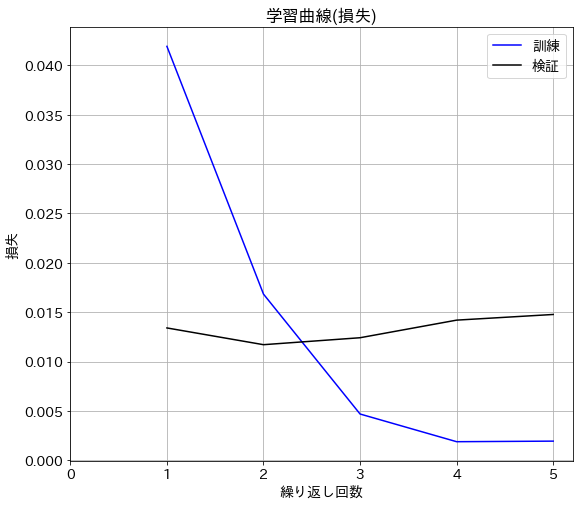

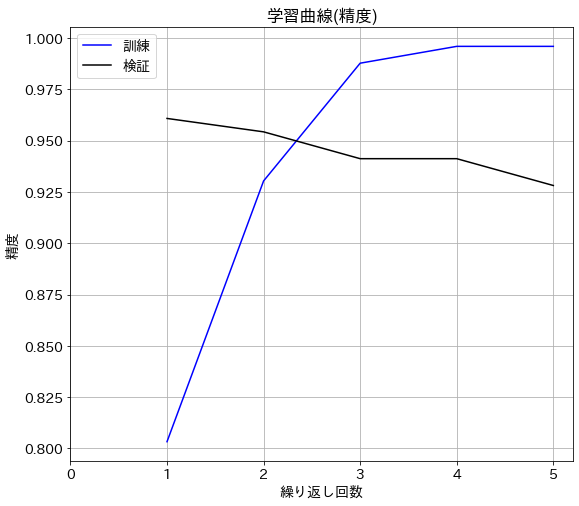

In [ ]:
# 結果確認
evaluate_history(history)

augmentation ありのときの精度
* 初期状態: 損失: 0.01104 精度: 0.96078
* 最終状態: 損失: 0.01318 精度: 0.94771

augmentation なしのときの精度
* 初期状態: 損失: 0.01341 精度: 0.96078
* 最終状態: 損失: 0.01477 精度: 0.92810

## 課題2 オオカミ、いぬ

In [ ]:
# データダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 解凍
!unzip dog_wolf.zip | tail -n 1

# 解凍結果のツリー表示
!tree dog_wolf

2022-08-22 06:09:20 (145 MB/s) - ‘dog_wolf.zip’ saved [21811374/21811374]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├─

### transforms

In [ ]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [ ]:
# データセット定義

data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)


In [ ]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


In [ ]:
# データローダー定義

batch_size = 5
# 学習データ
train_loader = DataLoader(train_data, 
            batch_size=batch_size, shuffle=True)
# 学習データ　イメージ表示用
train_loader2 = DataLoader(train_data2, 
            batch_size=40, shuffle=False)
# 検証データ
test_loader = DataLoader(test_data, 
            batch_size=batch_size, shuffle=False)
# 検証データ　イメージ表示用
test_loader2 = DataLoader(test_data, 
            batch_size=10, shuffle=True)

In [ ]:
# 学習済みモデルの読み込み
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

lr = 0.001
# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習の実行

num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.11843 acc: 0.62500 val_loss: 0.08107, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.06555 acc: 0.90000 val_loss: 0.07606, val_acc: 0.70000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.02975 acc: 0.95000 val_loss: 0.03723, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.03671 acc: 0.95000 val_loss: 0.04293, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.03356 acc: 0.92500 val_loss: 0.07835, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.01711 acc: 1.00000 val_loss: 0.08290, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.01855 acc: 0.95000 val_loss: 0.08180, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.01325 acc: 1.00000 val_loss: 0.08665, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01129 acc: 0.97500 val_loss: 0.08128, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00393 acc: 1.00000 val_loss: 0.10123, val_acc: 0.80000


初期状態: 損失: 0.08107 精度: 0.90000
最終状態: 損失: 0.10123 精度: 0.80000


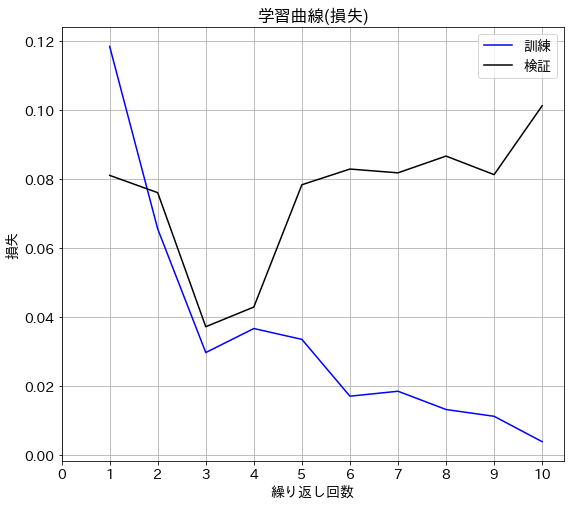

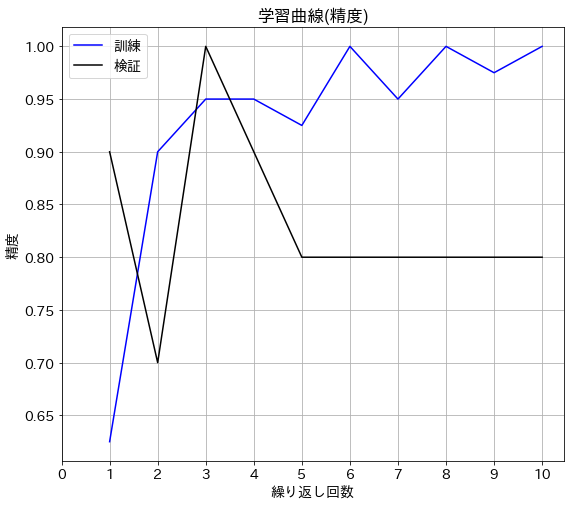

In [ ]:
# 結果サマリー
evaluate_history(history)

augmentationありのとき
* 初期状態: 損失: 0.07783 精度: 1.00000
* 最終状態: 損失: 0.03189 精度: 1.00000

augmentation なしのとき
* 初期状態: 損失: 0.08107 精度: 0.90000
* 最終状態: 損失: 0.10123 精度: 0.80000

# 課題1-b レイヤー追加

In [ ]:
# Transforms定義


# train transforms augmentation 無し
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# test transforms
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])



In [ ]:

# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [ ]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


In [ ]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

In [ ]:
# vgg19_bnのsummary
from torchvision import models
net = models.vgg19_bn(pretrained = True)

print(net)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### 事前学習済モデルに3そうのレイヤーを追加

In [ ]:
from torch.nn.modules.dropout import Dropout1d
# 事前学習済 3層のレイヤーを追加

class VGG19_bnAddDropout(nn.Module):
    
    def __init__(self, label_size):
        super().__init__()
        self.n_output = label_size

        self.backbone = models.vgg19_bn(pretrained = True)
        out_features = self.backbone.classifier[6].out_features
        self.l1 = nn.Linear(out_features, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(512, self.n_output)
        
        self.head = nn.Sequential(
            self.l1,
            self.dropout1,
            self.l2,
        )


    def forward(self, x):
        x1 = self.backbone(x)
        x2 = self.head(x1)
        return x2


In [ ]:
net = VGG19_bnAddDropout(label_size = 2)
print(net)

VGG19_bnAddDropout(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, p

In [ ]:
# Identityで置き換えする場所の確認
print(net.backbone.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [ ]:
# 3層追加したモデルで学習する。

# 乱数初期化
torch_seed()

# 
labels = 2
net = VGG19_bnAddDropout(labels)

# AdaptiveAvgPool2d関数の取り外し (再現性)
net.backbone.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)


# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
print(net)

VGG19_bnAddDropout(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, p

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.05997 acc: 0.75820 val_loss: 0.01627, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02936 acc: 0.86885 val_loss: 0.04674, val_acc: 0.81699


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02345 acc: 0.90164 val_loss: 0.01448, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02653 acc: 0.89344 val_loss: 0.02329, val_acc: 0.92157


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.02064 acc: 0.90574 val_loss: 0.02021, val_acc: 0.94771


初期状態: 損失: 0.01627 精度: 0.96078
最終状態: 損失: 0.02021 精度: 0.94771


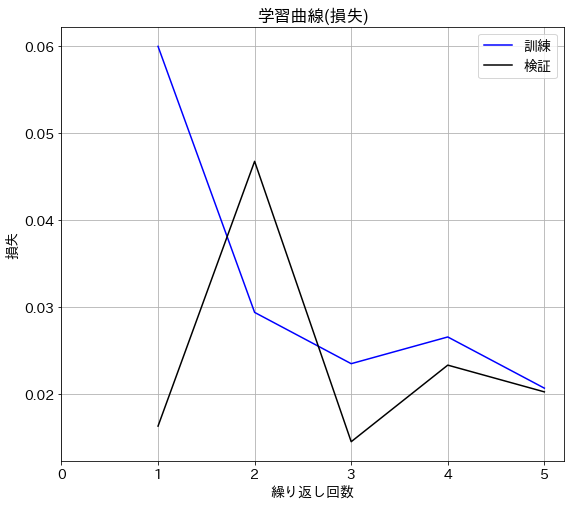

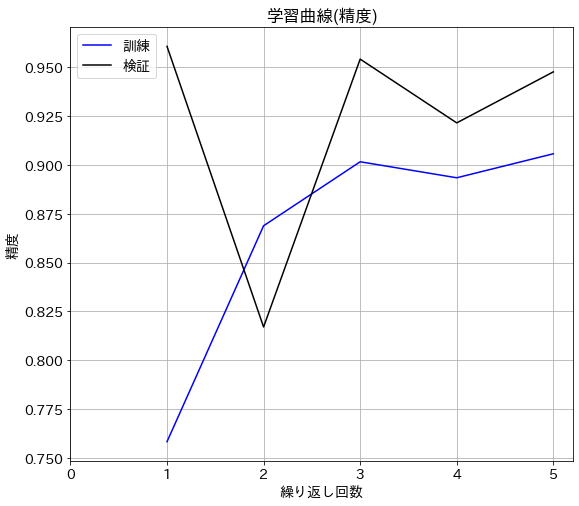

In [ ]:
# 結果確認
evaluate_history(history)

augmentation あり vgg19_bn単体
* 初期状態: 損失: 0.01104 精度: 0.96078
* 最終状態: 損失: 0.01318 精度: 0.94771

augmentation あり vgg19_bn + dropout
* 初期状態: 損失: 0.01627 精度: 0.96078
* 最終状態: 損失: 0.02021 精度: 0.94771



# 課題2


## 課題2-a

◆VGG16 
* ILSVRC（区分1）とはどんなコンペティションなのか 
    * 1400万枚の画像を1000分類し精度を競うコンペ（TBD）
* 何年に登場したのか 
    * 2014年
* 何層のモデルなのか 
    * 16層のCNN

◆Resnet18  
* 何年に登場したのか 
    * 2015年
* 何層のモデルなのか 
    * 18層のCNN
* Degradation problemとは 
    * 劣化問題
    * 層が深いと精度が高くなるはずが、精度が上がらなくなる問題
    * ⇨ 仮説: 恒等写像が学習できないから、精度があがらないのでは?
        * モデルの層が深いと、勾配が小さくなり学習が進まなくなる問題（これは勾配消失のことで劣化問題とは別）

* Residual learningとは
    * 残差学習
    * 出力と入力の差値を学習する
    * 学習したい関数をH(x)、 レイヤーの出力をF(x)、 入力値をxとおく
    * F(x) = H(x) - x
    * 変形して、 H(x) = F(x) + x
    * 学習が進むと、F(x) の出力は入力とほとんど差がなくなる
    * F(x)≒0のとき、 H(x) = x となるため、恒等写像を学習できるようになった。


## 課題2-b

In [ ]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])



In [ ]:

# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [ ]:

# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

In [ ]:
from torchvision import models
net = models.resnet18(pretrained = True)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをresnet18に置き換えた場合どうなるか。 pretrainで読み込む
from torchvision import models
# net = models.vgg19_bn(pretrained = True)
net = models.resnet18(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
net.fc.out_features = 2

# # AdaptiveAvgPool2d関数の取り外し resnetのときは取り外し不要
# net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.30984 acc: 0.51230 val_loss: 0.04205, val_acc: 0.86928


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.06583 acc: 0.79918 val_loss: 0.04318, val_acc: 0.87582


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.03240 acc: 0.87705 val_loss: 0.02284, val_acc: 0.91503


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02371 acc: 0.90984 val_loss: 0.02600, val_acc: 0.92810


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.02851 acc: 0.88525 val_loss: 0.02449, val_acc: 0.92810


初期状態: 損失: 0.04205 精度: 0.86928
最終状態: 損失: 0.02449 精度: 0.92810


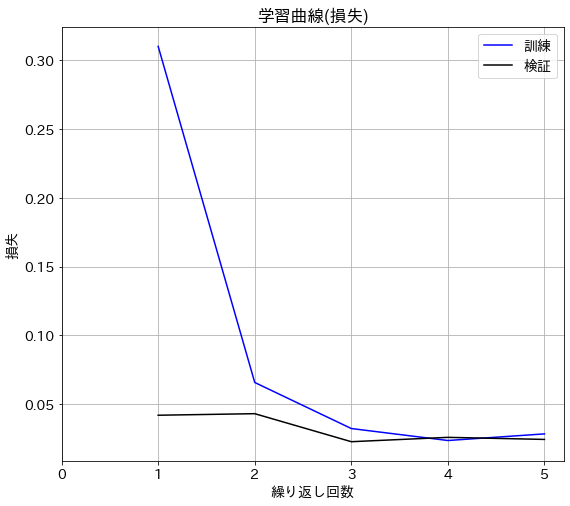

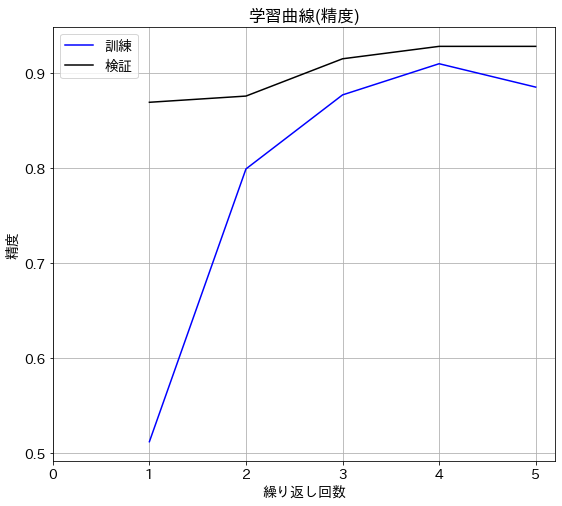

In [ ]:
# 結果確認
evaluate_history(history)

'''
vgg_bnの時は精度以下
初期状態: 損失: 0.01104 精度: 0.96078
最終状態: 損失: 0.01318 精度: 0.94771
'''

精度、損失はresnet18 < vgg16_bn という結果になった。

# 課題3

In [32]:
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

titanic_dataset = sns.load_dataset('titanic') 
titanic_dataset

X = titanic_dataset[['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked', 'class', 'who', 'adult_male', 'alone']] 
y = titanic_dataset['survived'] 

#標準化 
def trans_standardscaler(input_train, input_test): 
    scaler = StandardScaler() 
    scaler.fit(input_train) 
    input_train = scaler.transform(input_train) 
    input_test = scaler.transform(input_test) 
    return input_train, input_test 

category_col = ['sex', 'embarked', 'class', 'who', 'adult_male', 'alone']
num_col = ['pclass', 'age', 'fare', 'sibsp']

# 質的変数をencoding
X_onehot = pd.get_dummies(X[category_col], drop_first = True)
X_onehot['adult_male'] = X_onehot['adult_male'] * 1
X_onehot['alone'] = X_onehot['alone'] * 1
X = pd.concat([X[num_col], X_onehot], axis = 1)


# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
y_train, y_test = y_train.to_numpy(), y_test.to_numpy() 

# nanを平均で埋める
X_train.fillna(X_train['age'].mean(), inplace = True)
X_test.fillna(X_train['age'].mean(), inplace = True)

# 標準化
X_train[num_col], X_test[num_col] = trans_standardscaler(X_train[num_col],
                                                         X_test[num_col]
                                                        )
X_train

,pclass,age,fare,sibsp,adult_male,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman
6,-1.625803,1.892247e+00,0.387842,-0.469837,1,1,1,0,1,0,0,1,0
718,0.805762,-2.746837e-16,-0.319081,-0.469837,1,1,1,1,0,0,1,1,0
685,-0.410021,-3.499336e-01,0.187924,0.344183,1,0,1,0,0,1,0,1,0
73,0.805762,-2.726170e-01,-0.339412,0.344183,1,0,1,0,0,0,1,1,0
882,0.805762,-5.818833e-01,-0.415961,-0.469837,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.805762,-6.591999e-01,-0.471692,-0.469837,0,1,0,0,1,0,1,0,1
270,-1.625803,-2.746837e-16,-0.017745,-0.469837,1,1,1,0,1,0,0,1,0
860,0.805762,8.871317e-01,-0.346137,1.158202,1,0,1,0,1,0,1,1,0
435,-1.625803,-1.200416e+00,1.712501,0.344183,0,0,0,0,1,0,0,0,0


In [64]:
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
   
        # self.l1.weight.data.fill_(1.0)
        # self.l1.bias.data.fill_(1.0)        
        
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x)
        return x1

In [65]:
# 乱数初期化
torch_seed()

inputs = torch.tensor(X_train.values).float()
inputs_test = torch.tensor(X_test.values).float()

labels = torch.tensor(y_train).float()
labels = labels.view(-1,1)
labels_test = torch.tensor(y_test).float()
labels_test = labels_test.view(-1,1)


# model def
n_input = X_train.shape[1]
n_output = 1
net = Net(n_input, n_output)

# learning rate
lr = 0.01

# 損失関数
criterion = nn.BCEWithLogitsLoss() # sigmoid -> BCELoss

# 勾配降下法
optimizer = optim.SGD(net.parameters(), lr = lr)

# epoch
num_epochs = 10000

# history
history = np.zeros((0,5))



In [66]:
# fit

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    # 損失の保存(スカラー値の取得)
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 損失の保存（スカラー値の取得）
    val_loss =  loss_test.item()
        
    # 予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 0.64274 acc: 0.62752 val_loss: 0.65686, val_acc: 0.59322
Epoch [10/10000], loss: 0.63350 acc: 0.62752 val_loss: 0.64700, val_acc: 0.59322
Epoch [20/10000], loss: 0.62508 acc: 0.62752 val_loss: 0.63794, val_acc: 0.59322
Epoch [30/10000], loss: 0.61736 acc: 0.62752 val_loss: 0.62957, val_acc: 0.59322
Epoch [40/10000], loss: 0.61026 acc: 0.62752 val_loss: 0.62180, val_acc: 0.59322
Epoch [50/10000], loss: 0.60370 acc: 0.62752 val_loss: 0.61456, val_acc: 0.59322
Epoch [60/10000], loss: 0.59761 acc: 0.62752 val_loss: 0.60779, val_acc: 0.59322
Epoch [70/10000], loss: 0.59193 acc: 0.62752 val_loss: 0.60144, val_acc: 0.59322
Epoch [80/10000], loss: 0.58662 acc: 0.62752 val_loss: 0.59546, val_acc: 0.59322
Epoch [90/10000], loss: 0.58165 acc: 0.62752 val_loss: 0.58982, val_acc: 0.59322
Epoch [100/10000], loss: 0.57697 acc: 0.62752 val_loss: 0.58448, val_acc: 0.59322
Epoch [110/10000], loss: 0.57256 acc: 0.62752 val_loss: 0.57942, val_acc: 0.59322
Epoch [120/10000], loss: 0.

array([2920.     ,    0.43988,    0.8104 ,    0.41376,    0.82712])

max val acc info
Epoch [2920.0/10000], loss: 0.43988 acc: 0.81040 val_loss: 0.41376, val_acc: 0.82712
初期状態: 損失: 0.65686 精度: 0.59322
最終状態: 損失: 0.41011 精度: 0.81017


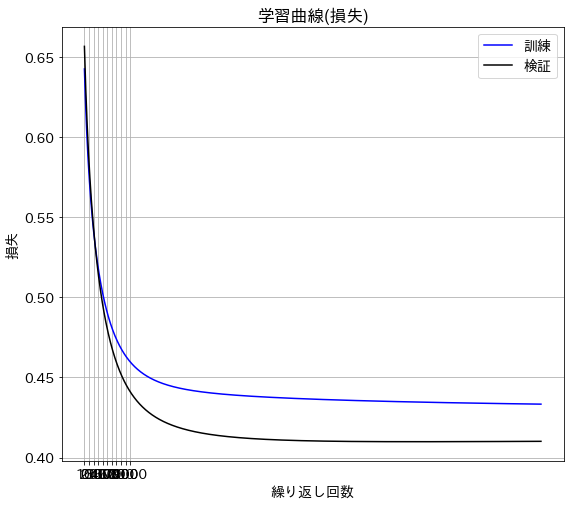

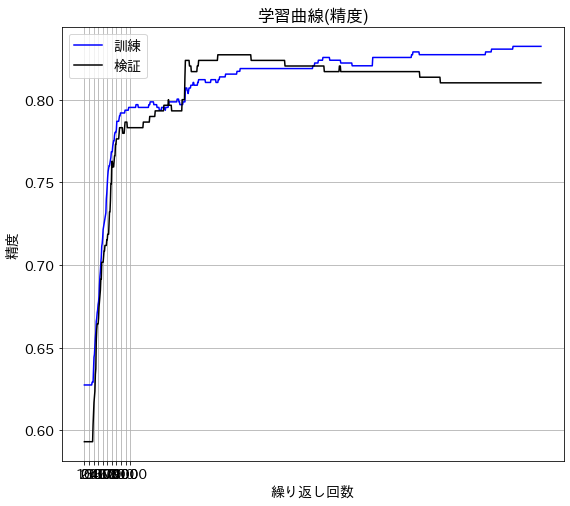

In [73]:
# val_accが最大の箇所を抽出
max_index = history[:, 4].argmax()
epoch_ = history[max_index, 0]
train_loss_ = history[max_index, 1]
train_acc_ = history[max_index, 2]
val_loss_ = history[max_index, 3]
val_acc_ = history[max_index, 4]

print('max val acc info')
print (f'Epoch [{epoch_}/{num_epochs}], loss: {train_loss_:.5f} acc: {train_acc_:.5f} val_loss: {val_loss_:.5f}, val_acc: {val_acc_:.5f}')


evaluate_history(history)


## モデルの改善1
過学習気味なので、dropout を追加してみる。

In [74]:
class Net2(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        n_hidden = int(n_input/2)
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(p=0.5)
  
        
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.dropout(x1)
        x3 = self.l2(x2)
        return x3

In [75]:
inputs = torch.tensor(X_train.values).float()
inputs_test = torch.tensor(X_test.values).float()

labels = torch.tensor(y_train).float()
labels = labels.view(-1,1)
labels_test = torch.tensor(y_test).float()
labels_test = labels_test.view(-1,1)


# model def
n_input = X_train.shape[1]
n_output = 1
net = Net2(n_input, n_output)

# learning rate
lr = 0.01

# 損失関数
criterion = nn.BCEWithLogitsLoss()

# 勾配降下法
optimizer = optim.SGD(net.parameters(), lr = lr)

# epoch
num_epochs = 10000

# history
history = np.zeros((0,5))

In [76]:
# fit

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    # 損失の保存(スカラー値の取得)
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 損失の保存（スカラー値の取得）
    val_loss =  loss_test.item()
        
    # 予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 0.71495 acc: 0.59564 val_loss: 0.70530, val_acc: 0.59661
Epoch [10/10000], loss: 0.70331 acc: 0.59732 val_loss: 0.69482, val_acc: 0.57288
Epoch [20/10000], loss: 0.69997 acc: 0.59396 val_loss: 0.68198, val_acc: 0.58644
Epoch [30/10000], loss: 0.67821 acc: 0.61745 val_loss: 0.67462, val_acc: 0.59322
Epoch [40/10000], loss: 0.67005 acc: 0.62416 val_loss: 0.66265, val_acc: 0.58644
Epoch [50/10000], loss: 0.66135 acc: 0.62248 val_loss: 0.66903, val_acc: 0.60000
Epoch [60/10000], loss: 0.65814 acc: 0.62752 val_loss: 0.66399, val_acc: 0.58983
Epoch [70/10000], loss: 0.64523 acc: 0.62752 val_loss: 0.64422, val_acc: 0.60339
Epoch [80/10000], loss: 0.64382 acc: 0.62081 val_loss: 0.64884, val_acc: 0.58983
Epoch [90/10000], loss: 0.64452 acc: 0.61913 val_loss: 0.63740, val_acc: 0.60678
Epoch [100/10000], loss: 0.63482 acc: 0.62752 val_loss: 0.63893, val_acc: 0.60000
Epoch [110/10000], loss: 0.63603 acc: 0.63423 val_loss: 0.62809, val_acc: 0.60678
Epoch [120/10000], loss: 0.

max val acc info
Epoch [9950.0/10000], loss: 0.44855 acc: 0.80537 val_loss: 0.42918, val_acc: 0.82712
初期状態: 損失: 0.70530 精度: 0.59661
最終状態: 損失: 0.44020 精度: 0.78305


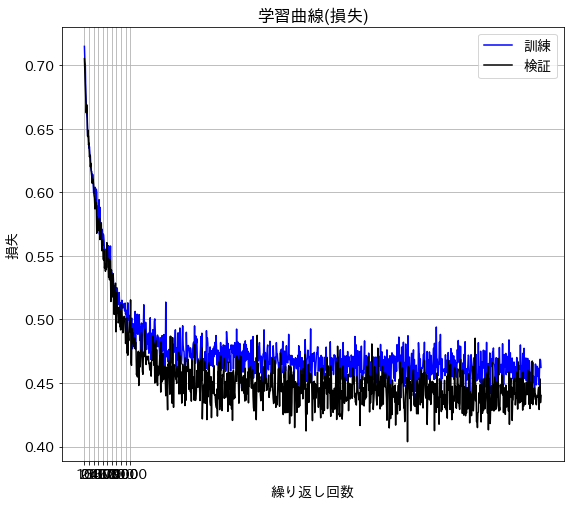

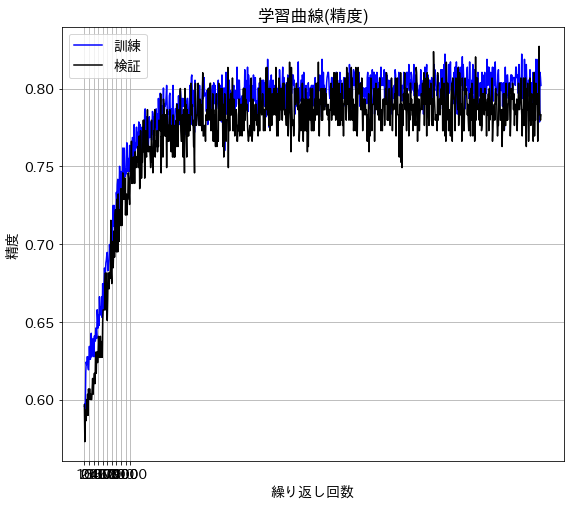

In [77]:
# val_accが最大の箇所を抽出
max_index = history[:, 4].argmax()
epoch_ = history[max_index, 0]
train_loss_ = history[max_index, 1]
train_acc_ = history[max_index, 2]
val_loss_ = history[max_index, 3]
val_acc_ = history[max_index, 4]

print('max val acc info')
print (f'Epoch [{epoch_}/{num_epochs}], loss: {train_loss_:.5f} acc: {train_acc_:.5f} val_loss: {val_loss_:.5f}, val_acc: {val_acc_:.5f}')


evaluate_history(history)


ガタガタになった。  
* 線形は何回通しても線形
* dropoutを挟むことで、項の情報が消える（次段に伝わらない）
* 学習ごとにランダムに項の情報が消えるので、都度 線形回帰の精度が変わってしまい、ガタガタな波形になった。

→ dropoutではなくRELUを通して非線形モデルにする。


## モデル改善2
Linear → Relu → Linear

In [78]:
class Net3(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        n_hidden = int(n_input/2)
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        # self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [79]:
inputs = torch.tensor(X_train.values).float()
inputs_test = torch.tensor(X_test.values).float()

labels = torch.tensor(y_train).float()
labels = labels.view(-1,1)
labels_test = torch.tensor(y_test).float()
labels_test = labels_test.view(-1,1)


# model def
n_input = X_train.shape[1]
n_output = 1
net = Net3(n_input, n_output)

# learning rate
lr = 0.01

# 損失関数
criterion = nn.BCEWithLogitsLoss()

# 勾配降下法
optimizer = optim.SGD(net.parameters(), lr = lr)

# epoch
num_epochs = 10000

# history
history = np.zeros((0,5))

In [80]:
# fit

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    # 損失の保存(スカラー値の取得)
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 損失の保存（スカラー値の取得）
    val_loss =  loss_test.item()
        
    # 予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 0.70889 acc: 0.62752 val_loss: 0.71079, val_acc: 0.59322
Epoch [10/10000], loss: 0.70485 acc: 0.62752 val_loss: 0.70721, val_acc: 0.59322
Epoch [20/10000], loss: 0.70112 acc: 0.62752 val_loss: 0.70390, val_acc: 0.59322
Epoch [30/10000], loss: 0.69765 acc: 0.62752 val_loss: 0.70084, val_acc: 0.59322
Epoch [40/10000], loss: 0.69442 acc: 0.62752 val_loss: 0.69798, val_acc: 0.59322
Epoch [50/10000], loss: 0.69139 acc: 0.62752 val_loss: 0.69530, val_acc: 0.59322
Epoch [60/10000], loss: 0.68853 acc: 0.62752 val_loss: 0.69277, val_acc: 0.59322
Epoch [70/10000], loss: 0.68582 acc: 0.62752 val_loss: 0.69038, val_acc: 0.59322
Epoch [80/10000], loss: 0.68323 acc: 0.62752 val_loss: 0.68809, val_acc: 0.59322
Epoch [90/10000], loss: 0.68075 acc: 0.62752 val_loss: 0.68590, val_acc: 0.59322
Epoch [100/10000], loss: 0.67838 acc: 0.62752 val_loss: 0.68378, val_acc: 0.59322
Epoch [110/10000], loss: 0.67611 acc: 0.62752 val_loss: 0.68175, val_acc: 0.59322
Epoch [120/10000], loss: 0.

max val acc info
Epoch [2160.0/10000], loss: 0.44281 acc: 0.81544 val_loss: 0.40761, val_acc: 0.82712
初期状態: 損失: 0.71079 精度: 0.59322
最終状態: 損失: 0.40504 精度: 0.80678


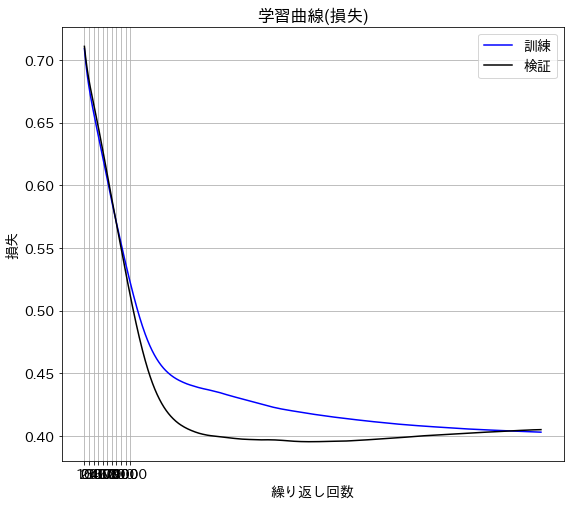

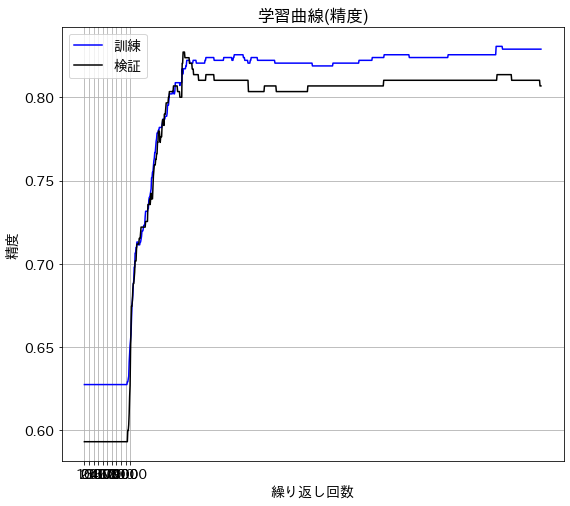

In [81]:
# val_accが最大の箇所を抽出
max_index = history[:, 4].argmax()
epoch_ = history[max_index, 0]
train_loss_ = history[max_index, 1]
train_acc_ = history[max_index, 2]
val_loss_ = history[max_index, 3]
val_acc_ = history[max_index, 4]

print('max val acc info')
print (f'Epoch [{epoch_}/{num_epochs}], loss: {train_loss_:.5f} acc: {train_acc_:.5f} val_loss: {val_loss_:.5f}, val_acc: {val_acc_:.5f}')


evaluate_history(history)
